In [137]:
#Accelerator-GPU P100
from datasets import load_dataset
import matplotlib.pyplot as plt

In [138]:
emotions =load_dataset("emotion", download_mode="force_redownload")

/opt/conda/lib/python3.10/site-packages/datasets/load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [139]:
emotions["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [140]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_ds=emotions["train"]
device

device(type='cuda')

In [141]:
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [142]:
train_ds[1]

{'text': 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'label': 0}

In [143]:
import pandas as pd

In [144]:
emotions.set_format(type="pandas")
df=emotions["train"][:]

In [145]:
df.head(5)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [146]:
def label_int2str(row,split):
    return emotions[split].features["label"].int2str(row)

In [147]:
df["label_name"]=df["label"].apply(label_int2str,split="train")
df.head(5)
labels=list(df["label_name"].unique())
labels

['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']

<Axes: xlabel='label_name'>

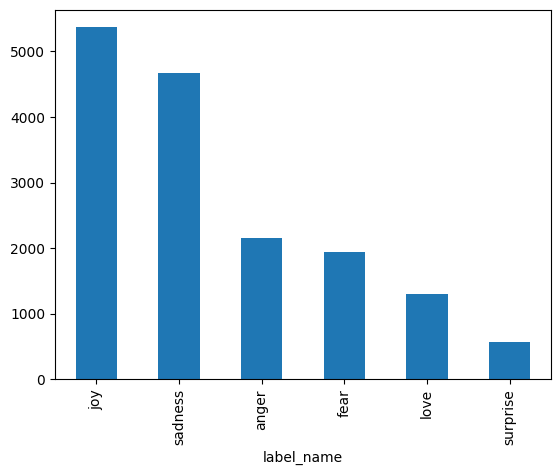

In [148]:
df["label_name"].value_counts().plot.bar()

<Axes: title={'center': 'Words per Tweet '}, xlabel='label_name'>

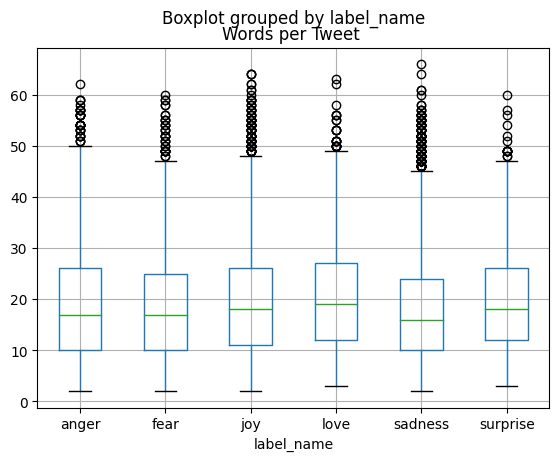

In [149]:
df["Words per Tweet "]=df["text"].str.split().apply(len)
df.boxplot("Words per Tweet ",by="label_name")

In [150]:
from transformers import AutoTokenizer
model_name="distilbert-base-uncased"
tokenizer=AutoTokenizer.from_pretrained(model_name)

In [151]:
import torch

In [152]:
text="This is a text"

In [153]:
from transformers import AutoModel
text_tensor=tokenizer.encode(text,return_tensors="pt")
model=AutoModel.from_pretrained(model_name).to("cuda")

In [154]:
def tokenize(batch):
    return tokenizer(batch["text"],padding=True,truncation=True)

In [155]:
emotions.reset_format()

In [156]:
emotions["train"][1]

{'text': 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'label': 0}

In [157]:
emotions_encoded=emotions.map(tokenize,batched=True,batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [158]:
emotions_encoded["train"][1]

{'text': 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'label': 0,
 'input_ids': [101,
  1045,
  2064,
  2175,
  2013,
  3110,
  2061,
  20625,
  2000,
  2061,
  9636,
  17772,
  2074,
  2013,
  2108,
  2105,
  2619,
  2040,
  14977,
  1998,
  2003,
  8300,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [159]:
import numpy as np

In [160]:
import numpy as np
def forward_pass(batch):
    input_ids = torch.tensor(batch["input_ids"]).to("cuda")
    attention_mask = torch.tensor(batch["attention_mask"]).to("cuda")
    with torch.no_grad():
        last_hidden_state = model(input_ids, attention_mask).last_hidden_state
        last_hidden_state = last_hidden_state.cpu().numpy()
 # Use average of unmasked hidden states for classification
    lhs_shape = last_hidden_state.shape
    boolean_mask = ~np.array(batch["attention_mask"]).astype(bool)
    boolean_mask = np.repeat(boolean_mask, lhs_shape[-1], axis=-1)
    boolean_mask = boolean_mask.reshape(lhs_shape)
    
    masked_mean = np.ma.array(last_hidden_state, mask=boolean_mask).mean(axis=1)
    
    batch["hidden_state"] = masked_mean.data
    return batch


In [ ]:

emotions_encoded = emotions_encoded.map(forward_pass, batched=True,
 batch_size=16)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

In [ ]:
emotions_encoded["train"].features


In [ ]:
import numpy as np

In [ ]:
X_train=np.array(emotions_encoded["train"]["hidden_state"])

In [ ]:
X_valid=np.array(emotions_encoded["validation"]["hidden_state"])

In [ ]:
y_train=np.array(emotions_encoded["train"]["label"])

In [ ]:
y_valid=np.array(emotions_encoded["validation"]["label"])

In [ ]:
X_train.shape

In [ ]:
X_valid.shape

In [ ]:
from umap import UMAP

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
X_scaled=MinMaxScaler().fit_transform(X_train)

In [ ]:
mapper=UMAP(n_components=2,metric="cosine").fit(X_scaled)

In [ ]:
df_emb=pd.DataFrame(mapper.embedding_,columns=['X','Y'])

In [ ]:
df_emb['label'] = y_train


In [ ]:
df_emb.head(5)

# PLOTTING LABEL WISE TO SEE SIMILARITIES/DIFFERENCES BETWEEN TENSOR VECTOR OF DIFFERENT LABELS.

In [ ]:
fig,axes=plt.subplots(2,3)
axes=axes.flatten()
labels=["sadness","joy","love","anger","fear","surprise"]
cmaps=["Greys","Blues","Oranges","Reds","BuPu","Greens"]
for i,(label,cmap) in enumerate(zip(labels,cmaps)):
    df_emb_sub=df_emb.query(f"label=={i}")
    axes[i].hexbin(df_emb_sub["X"],df_emb_sub["Y"],cmap=cmap,gridsize=20)
    axes[i].set_title(label)
    axes[i].set_xticks([])


# PERFORMING BASIC PREDICTIONS USING LOGISTIC REGRESSIONS (SKLEARN)

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
np.__version__

In [ ]:
lr=LogisticRegression(n_jobs=-1,penalty=None)

In [ ]:
lr.fit(X_train,y_train)

In [ ]:
lr.score(X_valid,y_valid)  #PRINTS ACCURACY ON VALIDATION DATA

# USING DUMMY CLASSIFIER (SKLEARN) TO COMPARE RESULT WITH LOGISTIC REGRESSION ACCURACY

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
dum=DummyClassifier(strategy="uniform")

In [ ]:
dum.fit(X_train,y_train)

In [ ]:
dum.score(X_valid,y_valid) #ACCURACY OF DUMMY CLASSIFIER

# DUMMY CLASSIFIER ACCURACY IS 35.2% AND THAT OF LOGISTIC REGRESSION IS 65.25%

In [ ]:
y_preds=dum.predict(X_valid)

In [ ]:
len(y_preds)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_preds, target_names=labels))

In [ ]:
from transformers import AutoModelForSequenceClassification

In [ ]:
num_labels=6

In [ ]:
device=torch.device("cpu")
model=AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=num_labels).to(device)

In [ ]:
emotions_encoded.set_format("torch",columns=["input_ids","attention_mask","label"])

In [ ]:
emotions_encoded["train"][0]

In [ ]:
from sklearn.metrics import accuracy_score,f1_score

In [ ]:
def compute_metrics(pred):
    labels=pred.label_ids
    preds=pred.predictions.argmax(-1)
    f1=f1_score(labels,preds,average="weighted")
    acc=accuracy_score(labels,preds)
    return {"accuracy":acc,"f1":f1}

In [ ]:
from transformers import Trainer,TrainingArguments

In [ ]:
batch_size=64
logging_steps=len(emotions_encoded["train"])//batch_size


In [ ]:
training_args=TrainingArguments(output_dir="results",num_train_epochs=2,learning_rate=2e-5,load_best_model_at_end=True,metric_for_best_model="f1",weight_decay=0.01,evaluation_strategy="epoch",disable_tqdm=False,logging_steps=logging_steps,save_strategy="epoch",)

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
from transformers import Trainer
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
training_args = TrainingArguments(output_dir="results",
 num_train_epochs=2,
 learning_rate=2e-5,
 per_device_train_batch_size=batch_size,
 per_device_eval_batch_size=batch_size,
 load_best_model_at_end=True,
 metric_for_best_model="f1",
 weight_decay=0.01,
 evaluation_strategy="epoch",
 disable_tqdm=False,
 logging_steps=logging_steps,
 save_strategy="epoch"
                                 )


In [ ]:
trainer = Trainer(model=model, args=training_args,
 compute_metrics=compute_metrics,
 train_dataset=emotions_encoded["train"],
 eval_dataset=emotions_encoded["validation"])
trainer.train();

In [ ]:

results=trainer.evaluate()

In [ ]:
results

In [ ]:
preds_output=trainer.predict(emotions_encoded["validation"])

In [ ]:
preds_output.metrics

In [ ]:
y_preds=np.argmax(preds_output.predictions,axis=1)

In [ ]:
print(classification_report(y_valid,y_preds,target_names=labels))

In [ ]:
tweet="i saw a movie today and it was really good"

In [ ]:
input_tensor=tokenizer.encode(tweet,return_tensors="pt").cuda()

In [ ]:
logits=model(input_tensor).logits

In [ ]:
logits

In [ ]:
softmax=torch.nn.Softmax(dim=1)
probs=softmax(logits)[0]

In [ ]:
probs=probs.cpu().detach().numpy()

In [ ]:
probs

In [ ]:
plt.bar(labels,100*probs)

In [ ]:
from torch.nn.functional import cross_entropy

In [ ]:
def forward_pass_with_label(batch):
    input_ids=torch.tensor(batch["input_ids"],device=device)
    attention_mask=torch.tensor(batch["attention_mask"],device=device)
    labels=torch.tensor(batch["label"],device=device)
    with torch.no_grad():
        output=model(input_ids,attention_mask)
        pred_label=torch.argmax(output.logits,axis=-1)
        loss=cross_entropy(output.logits,labels,reduction="none")
    batch["predicted_label"]=pred_label.cpu().numpy()
    batch["loss"]=loss.cpu().numpy()
    return batch
    

In [ ]:
emotions_encoded.reset_format()
emotions_encoded["validation"]=emotions_encoded["validation"].map(forward_pass_with_label,batched=True,batch_size=16)

In [ ]:
emotions_encoded.set_format("pandas")
cols=["text","label","predicted_label","loss"]
df_test=emotions_encoded["validation"][:][cols]
df_test["label"]=df_test["label"].apply(label_int2str,split="test")


In [ ]:
df["predicted_label"]=(df_test["predicted_label"].apply(label_int2str,split="test"))

In [ ]:
df_test.head(5)

In [ ]:
trainer.save_model("models/distilbert-emotion")
tokenizer.save_pretrained("models/distilbert-emotion")


In [ ]:
%cd /kaggle/working/

In [ ]:
from IPython.display import FileLinks
FileLinks(r'models')

In [ ]:
!transformers-cli login